[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dpholmes/DirectStiffnessMethod/blob/master/planarTruss.ipynb)

<h1>Direct Stiffness Method: Planar Truss</h1>
<h3>Structural Mechanics, Boston University</h3>
<h4>Prof. Douglas P. Holmes</h4>

The problem we're interested in solving is perhaps the simplest planar truss: <b>three bars</b> connected by <b>three pins</b> to form a right triangle. The lower left pin is where we will set the origin of our coordinate system, and it is resting on a simple support. The lower right pin forms the corner of the right triangle, and this support can roll in the horizontal ($x$) direction. We'll work with dimensionless quantities, and assign a length of $L=1$ to the sides adjacent and opposite to the origin. At the pin on the upper right of the truss, we'll apply a force whose components in the $x$ and $y$ directions are: $F_{x_3}=2$ and $F_{y_3}=1$, where the 3 denotes the number we'll assign to the node that the force is acting on. We'll assume that the bars of this truss can only withstand axial loading, and we will model them as <i>two-node bars</i>, i.e. linear springs with an effective spring stiffness of $k=EA/L$, where $E$ is Young's elastic modulus, and $A$ is the cross-sectional area. Our goal is to solve $\mathbf{F}=\mathbf{K}\mathbf{u}$ for this structure.

Our procedure for solving this problem will proceed as follows:
<ol>
    <li>Define the geometry and materials of the truss. Where are the nodes, what elements are connected by these nodes, and what are $E$ and $A$ for each element? </li>
    <li>What are the boundary conditions, e.g. constraints on displacements $\mathbf{u}$ and applied forces $\mathbf{F}$? </li>
    <li>Calculate $\mathbf{K}$.</li>
    <ol>
        <li>Calculate $\mathbf{K}_{el}$ for each element.</li>
        <li>Augment $\mathbf{K}_{el}$ to the size of $\mathbf{K}$ </li>
        <li>Add each augmented $\mathbf{K}_{el}$ to $\mathbf{K}$</li>
    </ol>
    <li>The system is underdetermined, so next we removed the known/specified displacements from $\mathbf{u}$ and solve for the displacements of the free nodes.</li>
    <li>To complete the problem, we solve for the unknown reaction forces in $\mathbf{F}$.
</ol>

In [1]:
# Here are some common libraries that expand the functionality of python
import math         # sine, cosine, sqrt, etc.
import numpy as np  # so we can work with matrices

import matplotlib
import matplotlib.pyplot as plt # plotting

<h2>Geometry, Materials, and Boundary Conditions</h2>
Here, we will define the ($x$,$y$) coordinates of each node.

In [2]:
# [x1,y1], ... the (x,y) position of node 1, 2, 3...
nodes = np.array([
    [0,0],
    [1,0],
    [1,1]
])
# a list of all the nodes
node_numbers = np.array([*range(len(nodes))])

Next, define the elements. I chose to do this such that element $e$ is connected to the $i$th and $j$th nodes, and has Young's modulus $E$, and cross sectional area $A$. 

In [3]:
# element e is connected at nodes i and j
# element e: [node i, node j, Young's Modulus, Cross Sectional Area] ... note: we'll calculate L later
elements = np.array([
    [1,2,10,1],
    [2,3,5,1],
    [1,3,20*math.sqrt(2), 1]
])

Let's plot our structure in its original, undeformed, or reference, state:

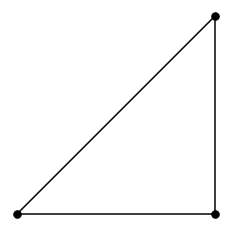

In [37]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
plt.show()

Now, we impose our boundary conditions. The Dirichlet conditions on displacement are typically inputted as list containing the node, the degree of freedom ($x=1$,$y=2$), and the magnitude of displacement.

In [6]:
# dirichlet boundary conditions
# [node, DoF (x=1, y=2), value]
bc = np.array([
    [1,1,0],
    [1,2,0],
    [2,2,0]
])

Forces are applied at node 3, we'll enter the node, degree of freedom, and magnitude.

In [7]:
# neumann boundary conditions - e.g. forces
# [node, DoF (x=1,y=2), magnitude of force]
forces = np.array([
    [3,1,2],
    [3,2,1]
])

<h2>Master Stiffness Matrix</h2>
First, we initialize our force and displacement vectors along with our master stiffness matrix. 

In [8]:
# initializing the vectors F, u, and the matrix K
F = u = np.zeros(2*len(nodes))
K = np.zeros([2*len(nodes), 2*len(nodes)])

It will be useful to convert the nodes into $x$, $y$ coordinates. We can use these coordinates to calculate $L$ for each element, as well as each element's angle from the horizontal plane defined by the coordinate system of the structure.

In [9]:
def XY(nodes, elements, i):
    return np.array([
        nodes[int(elements[i,0]-1)],
        nodes[int(elements[i,1]-1)]
    ])

Let's define a function to calculate the elemental stiffness matrix for each element. We'll use the notation $c \equiv \cos{\theta}$ and $s \equiv \sin{\theta}$. Recall that the $\cos{\theta}=\frac{x_2-x_1}{L}$ and $\sin{\theta}=\frac{y_2-y_1}{L}$.

In [10]:
# elemental stiffness matrix in global coordinates
def Kel(XY, E, A):
    x1, y1, x2, y2 = XY[0,0], XY[0,1], XY[1,0], XY[1,1]
    
    L = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    c = (x2-x1)/L
    s = (y2-y1)/L
    
    Kel = E*A/L*np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return Kel  

In order to be able to augment the elemental stiffness matrix, we need to know which nodes are <i>not</i> connected to a given element. So, I defined a function that determines that:

In [11]:
# What nodes are not connected to the ith element?
# list_of_all_nodes+1... the +1 is to align python numbering (starts at 0) with our numbering (starts at 1)
def missingNodes(list_of_all_nodes, list_of_element_nodes): 
    return (list(set(list_of_all_nodes+1) - set(list_of_element_nodes+1))) 

Now, we augment the stiffness matrix by adding rows and columns that correspond to the missing nodes..

In [12]:
# augment the elemental stiffness matrix by adding rows & columns of zeroes at the missing nodes
def Kaug(Kel, element):
    
    missing = missingNodes(node_numbers,elements[element,:2]-1)
    
    Kaug1 = np.insert(Kel, missing, 0, axis=0)
    Kaug2 = np.insert(Kaug1, missing, 0, axis=0)
    Kaug3 = np.insert(Kaug2, missing, 0, axis=1)
    Kaug  = np.insert(Kaug3, missing, 0, axis=1)
    return Kaug

In [13]:
def MasterStiffness(nodes, elements, K):
# Calculate the Master Stiffness matrix:
# 1. Get the x & y coordinates of each node connected to element i
# 2. Calculate the stiffness matrix for element i
# 3. Augment the elemental stiffness matrix to the size of K
# 4. Add it to K, loop over the remaining elements
    for i in range(len(elements)):
        nodesXY = XY(nodes, elements, i)
        Keli  = Kel(nodesXY, elements[i,2], elements[i,3])
        Kaugi = Kaug(Keli, i)
        K = np.add(K, Kaugi)    
    return K

<h3>Calculate $\mathbf{K}$</h3>

In [14]:
K = MasterStiffness(nodes, elements, K)

<h2>Solving for the displacements of the free nodes</h2>

In [15]:
# initialize vectors for the specified displacements and forces. these will be [1 x DoF]
u_specified=[]
F_specified=[0]*2*len(nodes)

# what DoF are specified?
for i in range(len(bc)):
    u_specified.append(2*(bc[i,0]-1)+bc[i,1]-1)
# assign the external forces to the corresponding DoF in F   
for i in range(len(forces)):    
    F_specified[(2*(forces[i,0]-1)+forces[i,1])-1]=forces[i,2]
    
u_unknown = np.delete(u,u_specified) # deleting the specified displacments from u
K_reduced = np.delete(K,u_specified,0) # deleting rows
K_reduced = np.delete(K_reduced,u_specified,1) # deleting columns
F_specified = np.delete(F_specified,u_specified) # deleting the forces that correspond to specified displacments

In [16]:
F_specified

array([0, 2, 1])

In [17]:
K_reduced

array([[10.,  0.,  0.],
       [ 0., 10., 10.],
       [ 0., 10., 15.]])

In [18]:
# np.linalg.lstsq does the matrix left division. 
# it returns the residuals, rank, etc. of the calculation, so we just grab the list, which is element [0]
u_unknown = np.linalg.lstsq(K_reduced,F_specified, rcond=None)[0]

In [19]:
u_unknown

array([ 0. ,  0.4, -0.2])

Putting the displacments of the free/unconstrained nodes back into the displacement vector $\mathbf{u}$.

In [20]:
# create a list of all the displacement degrees of freedom (DoF)
u_DoF=[]
for i in range(len(u)):
    u_DoF.append(i)

# get the index locations of the free degrees of freedom (DoF)    
u_free = (list(set(u_DoF) - set(u_specified)))    

# put the free (formerly unknown) displacements into the displacement vector u
np.put(u,u_free,u_unknown)

In [21]:
u

array([ 0. ,  0. ,  0. ,  0. ,  0.4, -0.2])

Solving for the unknown reaction forces.

In [22]:
F=np.dot(K,u)

In [23]:
F

array([-2., -2.,  0.,  1.,  2.,  1.])

<h2>Plotting the initial and deformed truss</h2>
First, let's collect the new location of the nodes.

In [24]:
nodes_new = nodes+np.reshape(u,(len(nodes),2))

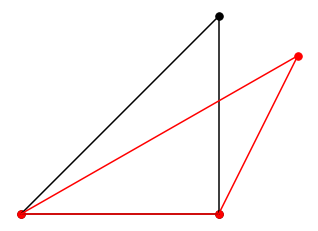

In [36]:
# set axes aspect ratio = 1
# turn off the axis
plt.axes().set_aspect('equal') 
plt.axis('off') 

# plot the nodes
plt.plot(nodes[:,0], nodes[:,1], 'k.',markersize=15)
plt.plot(nodes_new[:,0], nodes_new[:,1], 'r.',markersize=15)
# plot the elements
# loop through the list of elements, grab the x position and y position of each node associated with that element
# the line: 'elements[i,0]-1' is necessary because python starts counting at 0, not 1 (like MATLAB)
for i in range(len(elements)):
    plt.plot(np.array([
    nodes[int(elements[i,0]-1),0], nodes[int(elements[i,1]-1),0]]),
         np.array([nodes[int(elements[i,0]-1),1], nodes[int(elements[i,1]-1),1]]),
         'k-')
# plot the deformed elements
for i in range(len(elements)):
    plt.plot(np.array([
    nodes_new[int(elements[i,0]-1),0], nodes_new[int(elements[i,1]-1),0]]),
         np.array([nodes_new[int(elements[i,0]-1),1], nodes_new[int(elements[i,1]-1),1]]),
         'r-')    
plt.show()